In [1]:
import sys
import os
import glob

HOME_PATH = os.path.abspath("/root/work/QE-mls") # path to QE_mls
sys.path.append(HOME_PATH + "/qe")

import paper_plot as pp

plot = pp.Plotter()

import pandas as pd
import numpy as np
import scipy as sp
import ROOT
from ROOT import TLorentzVector, TVector3
import multiprocessing
WORKERS = 16

from matplotlib import pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


SEED = 42  # set random seed (global variable)
GEV = 1e-3

In [2]:
import full_data as data

# reco
lead_lep = data.Lead_lep()
sublead_lep = data.Sublead_lep()
met = data.Met()

# truth
truth_lead_lep = data.Truth_lead_lep()
truth_sublead_lep = data.Truth_sublead_lep()
Truth_dilep = data.Truth_dilep()
truth_met = data.Truth_met()

# target Ws
w_lead = data.Lead_w()
w_sublead = data.Sublead_w()
mc_weight = data.MC_weight()

['/CGLMP', '/RecoLep0', '/RecoLep1', '/RecoMET', '/TruthCandLep0', '/TruthCandLep1', '/TruthCandMET', '/TruthHiggs', '/TruthLep0', '/TruthLep1', '/TruthLepN', '/TruthLepP', '/TruthNu0', '/TruthNu1', '/TruthNuN', '/TruthNuP', '/TruthW0', '/TruthW1', '/TruthWN', '/TruthWP', '/eventWeight', '/mcWeight', '/recoWeight', '/weight']


In [3]:
# define preselection cuts

###############################################
# Truth sudy --> do not use cut at beginning! #
###############################################

cut_pre_pt_lead = lead_lep.pt > -999
print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = sublead_lep.pt > -999
print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > -999
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = met.pt > -999
print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)


0
0
0
0
0


In [4]:
# truth
truth_lead_lep_px = pd.DataFrame(truth_lead_lep.px[PRE_CUT])
truth_lead_lep_py = pd.DataFrame(truth_lead_lep.py[PRE_CUT])
truth_lead_lep_pz = pd.DataFrame(truth_lead_lep.pz[PRE_CUT])
truth_lead_lep_energy = pd.DataFrame(truth_lead_lep.energy[PRE_CUT])
truth_lead_lep_p4 = pd.concat(
	[truth_lead_lep_px, truth_lead_lep_py, truth_lead_lep_pz, truth_lead_lep_energy],
	axis=1,
).to_numpy()
truth_lead_lep_pt = pd.DataFrame(truth_lead_lep.pt[PRE_CUT])
truth_lead_lep_eta = pd.DataFrame(truth_lead_lep.eta[PRE_CUT])
truth_lead_lep_phi = pd.DataFrame(truth_lead_lep.phi[PRE_CUT])

truth_sublead_lep_px = pd.DataFrame(truth_sublead_lep.px[PRE_CUT])
truth_sublead_lep_py = pd.DataFrame(truth_sublead_lep.py[PRE_CUT])
truth_sublead_lep_pz = pd.DataFrame(truth_sublead_lep.pz[PRE_CUT])
truth_sublead_lep_energy = pd.DataFrame(truth_sublead_lep.energy[PRE_CUT])
truth_sublead_lep_p4 = pd.concat(
	[truth_sublead_lep_px, truth_sublead_lep_py, truth_sublead_lep_pz, truth_sublead_lep_energy],
	axis=1,
).to_numpy()
truth_sublead_lep_pt = pd.DataFrame(truth_sublead_lep.pt[PRE_CUT])
truth_sublead_lep_eta = pd.DataFrame(truth_sublead_lep.eta[PRE_CUT])
truth_sublead_lep_phi = pd.DataFrame(truth_sublead_lep.phi[PRE_CUT])

# reco
lead_lep_px = pd.DataFrame(lead_lep.px[PRE_CUT])
lead_lep_py = pd.DataFrame(lead_lep.py[PRE_CUT])
lead_lep_pz = pd.DataFrame(lead_lep.pz[PRE_CUT])
lead_lep_energy = pd.DataFrame(lead_lep.energy[PRE_CUT])
lead_lep_p4 = pd.concat(
	[lead_lep_px, lead_lep_py, lead_lep_pz, lead_lep_energy],
	axis=1,
).to_numpy()
lead_lep_pt = pd.DataFrame(lead_lep.pt[PRE_CUT])
lead_lep_eta = pd.DataFrame(lead_lep.eta[PRE_CUT])
lead_lep_phi = pd.DataFrame(lead_lep.phi[PRE_CUT])

sublead_lep_px = pd.DataFrame(sublead_lep.px[PRE_CUT])
sublead_lep_py = pd.DataFrame(sublead_lep.py[PRE_CUT])
sublead_lep_pz = pd.DataFrame(sublead_lep.pz[PRE_CUT])
sublead_lep_energy = pd.DataFrame(sublead_lep.energy[PRE_CUT])
sublead_lep_p4 = pd.concat(
	[sublead_lep_px, sublead_lep_py, sublead_lep_pz, sublead_lep_energy],
	axis=1,
).to_numpy()
sublead_lep_pt = pd.DataFrame(sublead_lep.pt[PRE_CUT])
sublead_lep_eta = pd.DataFrame(sublead_lep.eta[PRE_CUT])
sublead_lep_phi = pd.DataFrame(sublead_lep.phi[PRE_CUT])

met_px = pd.DataFrame(met.px[PRE_CUT])
met_py = pd.DataFrame(met.py[PRE_CUT])
met_pt = pd.DataFrame(met.pt[PRE_CUT])
met_phi = pd.DataFrame(met.phi[PRE_CUT])

In [5]:
# lead_lep w
w_lead_px = pd.DataFrame(w_lead.px[PRE_CUT])
w_lead_py = pd.DataFrame(w_lead.py[PRE_CUT])
w_lead_pz = pd.DataFrame(w_lead.pz[PRE_CUT])
w_lead_e = pd.DataFrame(w_lead.energy[PRE_CUT])
w_lead_pt = pd.DataFrame(w_lead.pt[PRE_CUT])
w_lead_eta = pd.DataFrame(w_lead.eta[PRE_CUT])
w_lead_phi = pd.DataFrame(w_lead.phi[PRE_CUT])
w_lead_m = pd.DataFrame(w_lead.m[PRE_CUT])

w_sublead_px = pd.DataFrame(w_sublead.px[PRE_CUT])
w_sublead_py = pd.DataFrame(w_sublead.py[PRE_CUT])
w_sublead_pz = pd.DataFrame(w_sublead.pz[PRE_CUT])
w_sublead_e = pd.DataFrame(w_sublead.energy[PRE_CUT])
w_sublead_pt = pd.DataFrame(w_sublead.pt[PRE_CUT])
w_sublead_eta = pd.DataFrame(w_sublead.eta[PRE_CUT])
w_sublead_phi = pd.DataFrame(w_sublead.phi[PRE_CUT])
w_sublead_m = pd.DataFrame(w_sublead.m[PRE_CUT])


In [ ]:
print("lead pt min: ", lead_lep_pt.min())
print("sublead pt min: ", sublead_lep_pt.min())

In [6]:
def pt_cut(lead=-999, sublead=-999):
	cut_pre_pt_lead = lead_lep.pt > lead
	# print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
	cut_pre_pt_sub = sublead_lep.pt > sublead
	# print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
	return cut_pre_pt_lead & cut_pre_pt_sub

In [7]:
lead_cut = np.linspace(15, 35, 81)
sublead_cut = np.linspace(5, 25, 81)
LeadWIsOnShell = np.zeros((len(lead_cut), len(sublead_cut)))
print(LeadWIsOnShell.shape)

for i_ind, i in enumerate(lead_cut):
	for j_ind, j in enumerate(sublead_cut):
		ptcut = pt_cut(lead=i, sublead=j)
		LeadWIsOnShell[i_ind, j_ind] = np.divide(np.sum(w_lead_m[ptcut] > w_sublead_m[ptcut]), len(w_lead_m[ptcut]), where=len(w_lead_m[ptcut]) != 0)

(81, 81)


/root/miniconda3/envs/tf/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/tmp/ipykernel_207313/3938686608.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  LeadWIsOnShell[i_ind, j_ind] = np.divide(np.sum(w_lead_m[ptcut] > w_sublead_m[ptcut]), len(w_lead_m[ptcut]), where=len(w_lead_m[ptcut]) != 0)


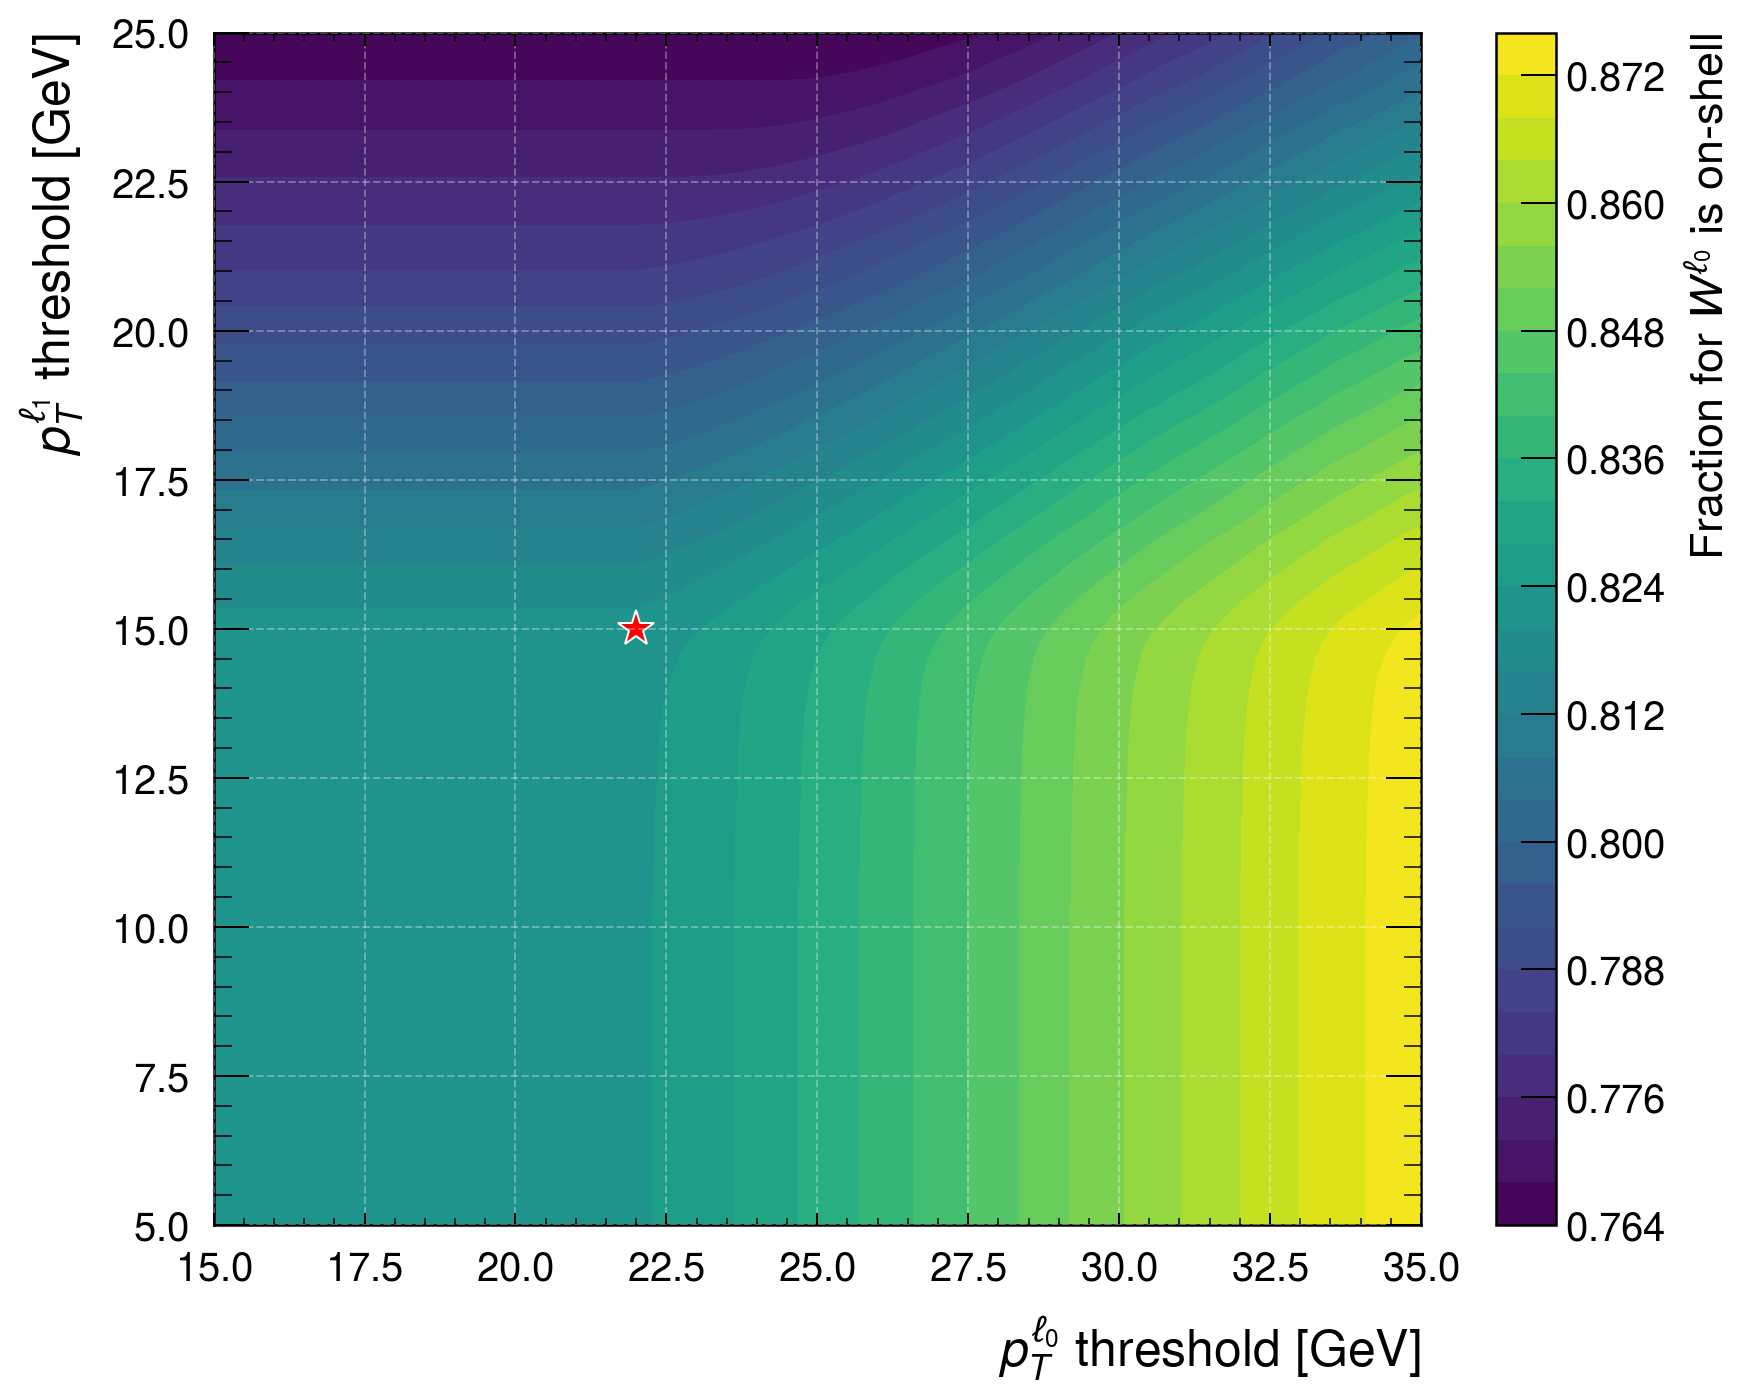

Fraction of events with leading W on-shell: 82.13


In [8]:
# Alternative: Contour plot
plt.figure(figsize=(10, 8), dpi=180)
X, Y = np.meshgrid(lead_cut, sublead_cut)
CS = plt.contourf(X, Y, LeadWIsOnShell.T, levels=30, cmap='viridis')
cbar = plt.colorbar(CS, label='Fraction of events with leading W on-shell')

# Add better font sizes to colorbar
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Fraction for $W^{\ell_0}$ is on-shell', fontsize=18)

lead_idx = np.abs(lead_cut - 22).argmin()
sublead_idx = np.abs(sublead_cut - 15).argmin()
value_at_point = LeadWIsOnShell[lead_idx, sublead_idx]
plt.plot(22, 15, 'r*', markersize=15, markeredgecolor='white', markeredgewidth=.8)
# plt.annotate(
#                 f'({22}, {15}): {100*value_at_point:.1f}%', 
#                 xy=(22, 15), 
#                 xytext=(22 + .6, 15 + .6),  # Offset text position
#                 fontsize=16,
#                 color='white',
#                 bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=.3')
#             )

plt.xlabel('$p^{\ell_0}_T$ threshold [GeV]', fontsize=20)
plt.ylabel('$p^{\ell_1}_T$ threshold [GeV]', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16, pad=10)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3, color='white')
plt.show()

cut_preintout = pt_cut(lead=22, sublead=15)
lead_onshell_printout = w_lead_m[cut_preintout] > w_sublead_m[cut_preintout]
print(f"Fraction of events with leading W on-shell: {100 * np.sum(lead_onshell_printout.to_numpy().flatten()*1) / len(lead_onshell_printout):.2f}")

Fraction of events with leading W on-shell: 82.35


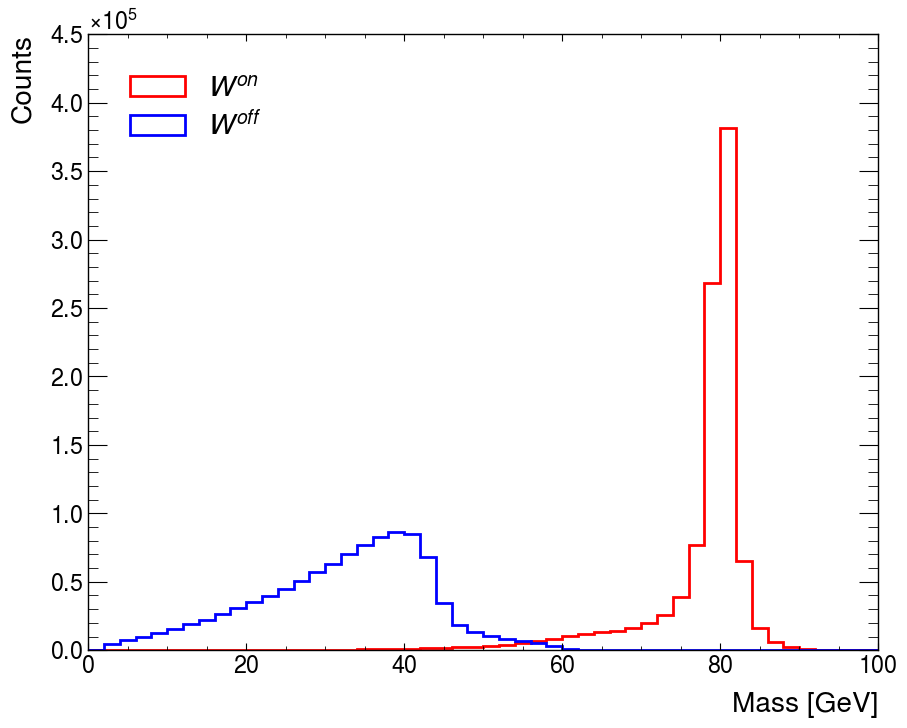

In [9]:
# target variables on-(off-)shell Ws

lead_onshell_mask = w_lead_m > w_sublead_m

print(f"Fraction of events with leading W on-shell: {100 * np.sum(lead_onshell_mask.to_numpy().flatten()*1) / len(lead_onshell_mask):.2f}")

onshell_w_m = pd.concat(
		[
			w_lead_m[lead_onshell_mask].dropna(), 
			w_sublead_m[~lead_onshell_mask].dropna(),
		], ignore_index=False
    ).sort_index()
offshell_w_m = pd.concat(
		[
			w_lead_m[~lead_onshell_mask].dropna(), 
			w_sublead_m[lead_onshell_mask].dropna(),
		], ignore_index=False
	).sort_index()

# check them with histograms
bin_edges = np.linspace(0, 100, 51)
figure = plt.figure(figsize=(10, 8))
plt.hist(
	onshell_w_m.values.ravel(),
	bins=bin_edges,
	color="red",
	# alpha=0.5,
	histtype="step",
	label=r"$W^{on}$",
	linewidth=2,
	stacked=False,
	density=False,
)
plt.hist(
	offshell_w_m.values.ravel(),
	bins=bin_edges,
	color="blue",
	# alpha=0.5,
	histtype="step",
	label=r"$W^{off}$",
	linewidth=2,
	stacked=False,
	density=False,
)
plt.xlabel(r"Mass [GeV]", labelpad=10)
plt.ylabel("Counts")
# plt.title(r"$m_{W}$", fontsize=26)
plt.legend(loc="best", prop={'size': 20})
plt.show()
plt.close()

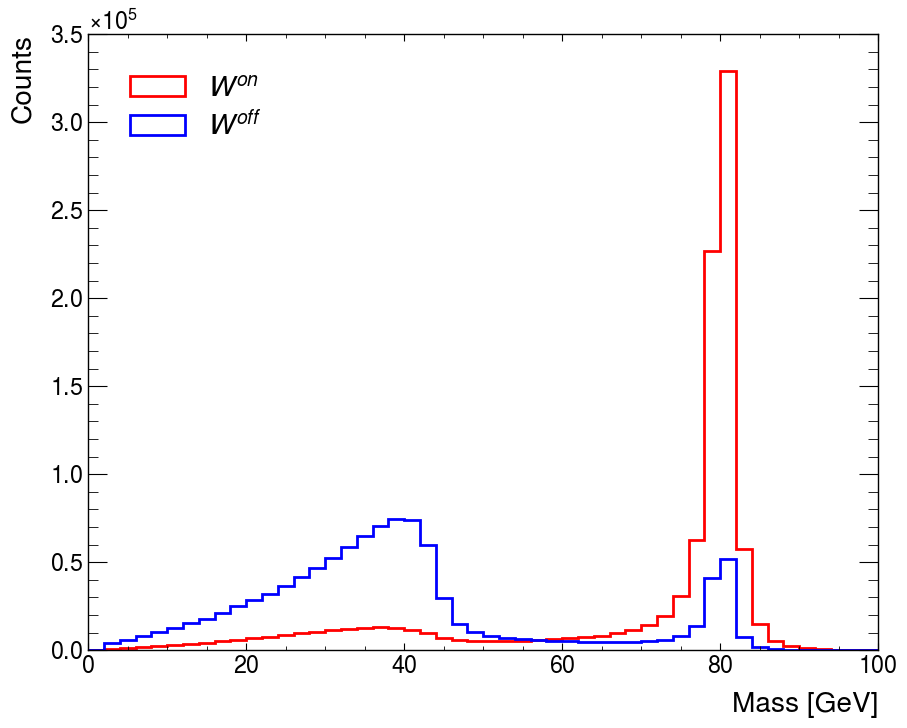

In [10]:
# check them with histograms

bin_edges = np.linspace(0, 100, 51)
figure = plt.figure(figsize=(10, 8))
plt.hist(
	w_lead_m,
	bins=bin_edges,
	color="red",
	# alpha=0.5,
	histtype="step",
	label=r"$W^{on}$",
	linewidth=2,
	stacked=False,
	density=False,
)
plt.hist(
	w_sublead_m,
	bins=bin_edges,
	color="blue",
	# alpha=0.5,
	histtype="step",
	label=r"$W^{off}$",
	linewidth=2,
	stacked=False,
	density=False,
)
plt.xlabel(r"Mass [GeV]", labelpad=10)
plt.ylabel("Counts")
# plt.title(r"$m_{W}$", fontsize=26)
plt.legend(loc="best", prop={'size': 20})
plt.show()
plt.close()